# Optimization - HW 2

Implement and test the conjugate-gradient method of optimization for multi-variable unconstrained optimization problems,  of dimensions at least 2 and 10. You may choose the problems but give them nontrivial dependencies among the variables. (For example, Rosenbrock’s function for dimension 2.) Parameters to vary include: number of CG iterates before restart; stopping criterion; others optional (eg control parameters or stopping criteria for the line minimization search). For each value of the parameters report (a) average error of the output argument vector and (b) function value produced by the algorithm, and also (c) total number of CG iterations (not sweeps) as a measure of computational cost, along with statistical error bars on those quantities. Probability distribution to use in producing a single average error measurement includes a distribution (eg a broad Gaussian) over starting points; just say what you chos

#### Some preliminaries: let's use Rosenbrock function as a performance test for our conjugate-gradient method

From wikipedia, the function is defined by

$f(x, y) = (x-a)^2 + b(x^2-y)^2$

The function has a global minimum at $(x, y) = (a, a^2)$. For simplicity, we'll set the parameters $a = 1$ and $b = 100$.

In [6]:
%matplotlib inline

In [23]:
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [39]:
def rosenbrock(x, y, a=1., b=100.):
    return (x - a)**2 + b*(x*x - y)**2

Let's take a look at the Rosenbrock function for $a=1, b=100$ 

In [40]:
s = 0.05
x = np.arange(-2, 2.+s, s)
y = np.arange(-2, 3.+s, s)
X, Y = np.meshgrid(x, y)

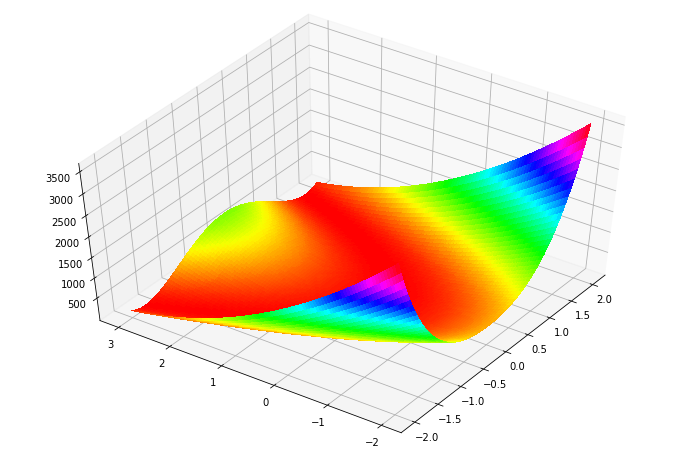

In [41]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')

ax.view_init(elev=50, azim=-145)
ax.plot_surface(X, Y, rosenbrock(X, Y), rstride=1, cstride=1,
                cmap=cm.hsv, linewidth=0, antialiased=False)

### Gradient of rosenbrock function

$$
\begin{align}
    \nabla f(x, y) &= \begin{bmatrix}
        \frac{\partial f(x, y)}{\partial x} \\
        \frac{\partial f(x, y)}{\partial y}
        \end{bmatrix} \\
     \nabla f(x, y) &= \begin{bmatrix}
         2(x-a) + 4bx(x^2-y) \\
         2b(y-x^2)
         \end{bmatrix}
\end{align}
$$

### Hessian of rosenbrock
$$
\begin{align}
{\nabla}^2 f(x, y) &= \begin{bmatrix}
    \frac{{\partial}^2 f(x, y)}{\partial x^2} &  \frac{{\partial}^2 f(x, y)}{\partial y \partial x} \\
    \frac{{\partial}^2 f(x, y)}{\partial y \partial x} &  \frac{{\partial}^2 f(x, y)}{\partial y^2}
    \end{bmatrix} \\
{\nabla}^2 f(x, y) &= \begin{bmatrix}
    2(6bx^2 - 2by + 1) & -4bx \\
    -4bx               & 2b
    \end{bmatrix}
\end{align}
$$

In [42]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

In [48]:
def rosen(x):
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [ ]:
def rosenbrock_grad(x, y, a=1, b=100):
    x_1 = 

In [ ]:
def rosenbrock_grad(x):
    """Gradient of Rosenbrock function"""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der